<a href="https://colab.research.google.com/github/yvesgit/UnpackAI/blob/main/Yves_NLP_Spam_sms_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 18.5MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 194kB 47.3MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [ ]:
from fastai.text.all import *

# Acquire data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Data/spam.csv',  header = 0, encoding='ISO-8859-1', usecols=[0, 1] , names = ['hamorspam', 'sms'])[['sms', 'hamorspam']]

In [ ]:
df.head(13)

,sms,hamorspam
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives around here though",ham
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",spam
6,Even my brother is not like to speak with me. They treat me like aids patent.,ham
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,ham
8,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,spam
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,spam


In [ ]:
df.shape

(5572, 2)

# Build Baseline

In [ ]:
dls = TextDataLoaders.from_df(df, valid_pct=0.2)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [48]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , xxunk the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you really do n't know me at all . xxmaj it was xxunk wednesday , but it was n't bad . xxmaj the problem i have with it is you xxup have the time to clean it , but you choose not to . xxmaj you skype , you take pictures , you sleep , you want to go out . i do n't mind a few things here and there , but when you do n't make the bed ,",ham
1,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , ' ' do u mind if i go into the bedroom for a minute ? '' ' ' ok ' ' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my",ham
2,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , ' ' do u mind if i go into the bedroom for a minute ? '' ' ' ok ' ' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my",ham


In [76]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Recall(), Precision(), F1Score(),CohenKappa()]) #, RocAuc()])

In [77]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.510891,0.182776,0.950628,0.811594,0.794326,0.802867,0.774652,00:06


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.197217,0.141544,0.965889,0.811594,0.903226,0.854962,0.835696,00:08
1,0.127924,0.126628,0.976661,0.840580,0.966667,0.899225,0.886099,00:08
2,0.072418,0.078257,0.984740,0.891304,0.984000,0.935361,0.926734,00:08
3,0.050310,0.085980,0.982944,0.862319,1.000000,0.926070,0.916490,00:08


In [78]:
learn.show_results(s_idx=2, max_n=100)

,text,category,category_
0,"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - maid : i went 2 d post office . 7.children : xxmaj we went 2 play . 8.neighbour : xxmaj we went 2 a marriage . xxmaj police arrested d murderer xxmaj immediately . xxmaj who 's xxmaj it ? xxmaj reply xxmaj with xxmaj reason , xxmaj if u r xxmaj brilliant .",ham,ham
1,"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - maid : i went 2 d post office . 7.children : xxmaj we went 2 play . 8.neighbour : xxmaj we went 2 a marriage . xxmaj police arrested d murderer xxmaj immediately . xxmaj who 's xxmaj it ? xxmaj reply xxmaj with xxmaj reason , xxmaj if u r xxmaj brilliant .",ham,ham
2,"xxbos xxmaj xxunk xxmaj xxunk : xxmaj if one xxmaj can do it , u too xxmaj can do it , xxmaj if none xxmaj can do it , u must do it xxmaj indian version : xxmaj if one xxmaj can do it , xxup let xxup him xxup do it .. xxmaj if none xxmaj can do it , leave it ! ! xxmaj and finally xxmaj kerala version : xxmaj if one can do it , xxmaj stop him doing it .. xxmaj if none can do it , xxmaj make a strike against it …",ham,ham
3,"xxbos xxmaj xxunk xxmaj xxunk : xxmaj if one xxmaj can do it , u too xxmaj can do it , xxmaj if none xxmaj can do it , u must do it xxmaj indian version : xxmaj if one xxmaj can do it , xxup let xxup him xxup do it .. xxmaj if none xxmaj can do it , leave it ! ! xxmaj and finally xxmaj kerala version : xxmaj if one can do it , xxmaj stop him doing it .. xxmaj if none can do it , xxmaj make a strike against it …",ham,ham
4,"xxbos xxmaj no i 'm not . i ca n't give you everything you want and need . xxmaj you actually could do better for yourself on yor own -- xxunk got more money than i do . i ca n't get work , i ca n't get a man , i ca n't pay the rent , i ca n't even fill my fucking gas xxunk . yes , i 'm xxunk and xxunk . i did n't even call home for thanksgiving cuz i 'll have to tell them i , m up to nothing .",ham,ham
5,"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say \ xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" margaret xxmaj hello "" xxmaj she is d girlfrnd f xxmaj grahmbell who invnted telphone … . . . . moral : one can 4get d name of a person",ham,ham
6,"xxbos xxmaj rose for red , red for blood , blood for heart , heart for u. xxmaj but u for me … . xxmaj send tis to all ur friends .. xxmaj including me .. xxmaj if u like me .. xxmaj if u get back , xxunk r poor in relation ! xxunk need some 1 to support xxunk r frnd 2 many xxunk xxunk u 5 + - some1 is xxunk god to marry xxunk ) try it … .",ham,ham
7,"xxbos i had been hoping i would not have to send you this message . xxmaj my rent is due and i do nt have enough for it . xxmaj my xxunk are completely gone . xxmaj its a loan i need and was hoping you could her . xxmaj the balance is < # > . xxmaj is there a way i could get that from you , till mid march when i hope to pay back .",ham,ham
8,"xxbos xxmaj for you information , xxup ikea is xxunk with all xxunk . xxmaj that is not xxunk . when you thought i had left you , you were sitting on the bed among the xxunk when i came in . i said we were going after you got home from class . please do n't try and xxunk me . xxmaj it makes me want to listen to you less .",ham,ham
9,xxbos xxup so xxup is xxup th xxup xxunk xxup mate xxup which xxup is xxup where i xxup am ! ? ! xxup how r u xxup

## Results

accuracy: 0.982944  	
recall_score: 0.862319 	
precision_score: 1.000000 	
f1_score: 0.926070 	
cohen_kappa_score: 0.916490

  	 	 	

# First Improvement: Use a pretrained Language Model

In [79]:
dls_lm = TextDataLoaders.from_df(df,  is_lm=True, valid_pct=0.2)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [199]:
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos somewhere out there xxunk the xxunk moon light someone think in of u some where out there where dreams come true … goodnite & & sweet dreams xxbos xxmaj you are not xxunk me but you have to trust my answers . xxmaj pls . xxbos xxmaj my mobile xxunk sms ur mail xxunk regards to xxunk , xxunk xxbos xxmaj alrite xxunk how s the xxunk goin ? xxmaj xxunk","somewhere out there xxunk the xxunk moon light someone think in of u some where out there where dreams come true … goodnite & & sweet dreams xxbos xxmaj you are not xxunk me but you have to trust my answers . xxmaj pls . xxbos xxmaj my mobile xxunk sms ur mail xxunk regards to xxunk , xxunk xxbos xxmaj alrite xxunk how s the xxunk goin ? xxmaj xxunk bin"
1,"with their xxunk … xxunk they hav gud xxunk dat xxunk problems . i sent dis 2 u , u wil get gud news on friday by d person you like . xxmaj and tomorrow will be the best day of your life . xxmaj do nt break this chain . xxmaj if you break you will xxunk . send this to < # > frnds in < # > mins xxunk","their xxunk … xxunk they hav gud xxunk dat xxunk problems . i sent dis 2 u , u wil get gud news on friday by d person you like . xxmaj and tomorrow will be the best day of your life . xxmaj do nt break this chain . xxmaj if you break you will xxunk . send this to < # > frnds in < # > mins xxunk u"
2,"xxmaj yo you around ? a friend of mine 's lookin to pick up later tonight xxbos xxmaj mm feeling xxunk . today itself i shall get that dear xxbos xxmaj night has ended for another day , morning has come in a special way . xxmaj may you smile like the sunny rays and leaves your worries at the blue blue bay . xxbos xxmaj just trying to figure out when","yo you around ? a friend of mine 's lookin to pick up later tonight xxbos xxmaj mm feeling xxunk . today itself i shall get that dear xxbos xxmaj night has ended for another day , morning has come in a special way . xxmaj may you smile like the sunny rays and leaves your worries at the blue blue bay . xxbos xxmaj just trying to figure out when xxmaj"
3,"xxmaj dat day ì _ send me da url ca nt work one … xxbos xxmaj so check your xxunk and if you had xxunk , do xxunk . xxbos xxmaj hi frnd , which is best way to xxunk xxunk wit our xxunk one 's ? xxbos g xxrep 5 e … xxmaj your internet is really bad today , eh ? xxbos xxmaj you always make things bigger than they","dat day ì _ send me da url ca nt work one … xxbos xxmaj so check your xxunk and if you had xxunk , do xxunk . xxbos xxmaj hi frnd , which is best way to xxunk xxunk wit our xxunk one 's ? xxbos g xxrep 5 e … xxmaj your internet is really bad today , eh ? xxbos xxmaj you always make things bigger than they are"
4,"air my xxunk on xxunk 2 b used 2 measure xxunk in next xxunk . xxmaj busy xxunk . :-) xxbos xxmaj studying . xxmaj but i.ll be free next weekend . xxbos xxmaj not course . xxmaj only xxunk one day one xxunk with in one month we can finish . xxbos xxmaj sorry man , my xxunk ran dry last night and i ca n't pick up more until sunday","my xxunk on xxunk 2 b used 2 measure xxunk in next xxunk . xxmaj busy xxunk . :-) xxbos xxmaj studying . xxmaj but i.ll be free next weekend . xxbos xxmaj not course . xxmaj only xxunk one day one xxunk with in one month we can finish . xxbos xxmaj sorry man , my xxunk ran dry last night and i ca n't pick up more until sunday xxbos"


In [80]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()],  wd=0.1).to_fp16()

In [81]:
learn_lm.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.061187,5.717118,0.156456,304.027374,00:06


In [82]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.488988,4.857678,0.199877,128.724945,00:06
1,5.125286,4.528504,0.226087,92.619888,00:06
2,4.858099,4.287972,0.244553,72.818642,00:06
3,4.643962,4.129861,0.260066,62.169273,00:06
4,4.428804,4.010485,0.271169,55.173634,00:06
5,4.238113,3.906535,0.287363,49.726357,00:06
6,4.078771,3.858526,0.293594,47.395416,00:06
7,3.954295,3.828236,0.297169,45.981373,00:06
8,3.845666,3.815830,0.299953,45.414455,00:06
9,3.780921,3.814644,0.299827,45.360611,00:06


In [83]:
learn_lm.save_encoder('finetuned')

In [89]:
TEXT = "I'm gonna be home as soon as"
N_WORDS = 20
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

print("\n".join(preds))

I 'm gon na be home as soon as i get to new shopping . Do nt think of you an idiot . You 're not
I 'm gon na be home as soon as i go pocketbabe.co.uk SMS AUCTION FROM TAKE ON to GET a FREE


In [90]:
dls_clas = TextDataLoaders.from_df(df, valid_pct=0.2, text_vocab=dls_lm.vocab)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [91]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Recall(), Precision(), F1Score(),CohenKappa()])

In [92]:
learn_clas = learn_clas.load_encoder('finetuned')

In [93]:
learn_clas.fit_one_cycle(1, 2e-2/4)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.410282,0.119671,0.974865,0.855072,0.936508,0.893939,0.879716,00:06


In [94]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.178866,0.064000,0.979354,0.927536,0.907801,0.917563,0.905763,00:06


In [95]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.083165,0.089709,0.977558,0.869565,0.944882,0.905660,0.892950,00:07


In [96]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.039304,0.104557,0.976661,0.826087,0.982759,0.897638,0.884578,00:08
1,0.037364,0.098509,0.979354,0.847826,0.983193,0.910506,0.898909,00:08


# Second Improvement: augment spam with translation

In [108]:
pip install google_trans_new

In [146]:
from textblob import TextBlob

In [148]:
blob = TextBlob('comment ca va ?')
result = blob.translate(to='en')

In [149]:
type(result)

textblob.blob.TextBlob

In [150]:
result.string

'How is it going ?'

In [182]:
from google_trans_new import google_translator
translator = google_translator()
def German_translation(x):           
  german_translation = translator.translate(x, lang_src='en', lang_tgt='de')        
  return german_translation

def English_blob_translation(x):      
  blob= TextBlob(x)   
  english_translation = blob.translate(to='en')     
  return english_translation.string

def English_gtn_translation(x):       
    english_translation = translator.translate(x, lang_src='de', lang_tgt='en')        
    return english_translation.text

In [114]:
German_translation('the rain in Spain stays mainly on the plain')

'Der Regen in Spanien bleibt hauptsächlich in der Ebene '

In [157]:
English_translation('Der Regen in Spanien bleibt hauptsächlich in der Ebene')

'The rain in Spain mainly stays in the plain'

In [102]:
trans_df = df[df['hamorspam'] == 'spam']
trans_df

,sms,hamorspam
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,spam
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",spam
8,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,spam
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,spam
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",spam
...,...,...
5537,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,spam
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O å£250 3 WANT å£800,spam
5547,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",spam
5566,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",spam


In [116]:
trans_df['sms'] = trans_df['sms'].apply(German_translation)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [118]:
trans_df.head(3)

,sms,hamorspam
2,"Freier Eintritt in 2 Wochen, um das FA Cup-Finale am 21. Mai 2005 zu gewinnen. Schreiben Sie FA an 87121, um eine Frage zur Teilnahme zu erhalten (Standard-Textrate). Die AGB gelten für 08452810075 über 18 Jahre",spam
5,"FreeMsg Hey Liebling, es ist jetzt 3 Wochen her und kein Wort zurück! Ich hätte gerne noch Spaß daran? Tb ok! XxX std chgs zu senden, å £ 1.50 an rcv",spam
8,"GEWINNER!! Als geschätzter Netzwerkkunde wurden Sie ausgewählt, um eine Preisprämie von £ 900 zu erhalten! Um einen Anspruch geltend zu machen, rufen Sie 09061701461 an. Anspruchscode KL341. Nur 12 Stunden gültig.",spam


In [186]:
trans_func ={'blob':English_blob_translation, 'gtn': English_gtn_translation }
def incr_trans(ind, func_short):
  func= trans_func.get(func_short)
  for index in range(ind, len(trans_df)):
    try:
      trans_df.loc[index,'sms'] = func(trans_df.loc[index,'sms'])
    except:
      print("index= ",index)
      break

In [216]:
incr_trans(60, 'blob')

index=  60


In [190]:
trans_df.iloc[59, 0:2]

sms          100 dating service cal; l 09064012103 box334sk38ch 
hamorspam                                                   spam
Name: 414, dtype: object

# Third Improvement: class weights

In [201]:
spam_prop = len(trans_df)/len(df)
ham_prop = 1 - spam_prop
norm_fact = 2* spam_prop * ham_prop
class_weights  = list((ham_prop/norm_fact, spam_prop/norm_fact))
class_weights = torch.FloatTensor(class_weights)
class_weights

tensor([3.7296, 0.5774])

In [198]:
learn_clas.loss_func

FlattenedLoss of CrossEntropyLoss()

In [202]:
learn_bal = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Recall(), Precision(), F1Score(),CohenKappa()])

In [205]:
learn_bal.loss_func = nn.CrossEntropyLoss(weight=class_weights.cuda())

In [206]:
learn_bal.loss_func

CrossEntropyLoss()

In [209]:
learn_bal = learn_clas.load_encoder('finetuned')

In [210]:
learn_bal.fit_one_cycle(1, 2e-2/4)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.072461,0.099043,0.980251,0.869565,0.967742,0.916031,0.904876,00:06


In [211]:
learn_bal.freeze_to(-2)
learn_bal.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.099214,0.209097,0.975763,0.818841,0.982609,0.893281,0.879737,00:07


In [212]:
learn_bal.freeze_to(-3)
learn_bal.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.049100,0.155723,0.982047,0.862319,0.991667,0.922481,0.912384,00:07


In [213]:
learn_bal.unfreeze()
learn_bal.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,cohen_kappa_score,time
0,0.031807,0.164823,0.982047,0.862319,0.991667,0.922481,0.912384,00:08
1,0.020429,0.130442,0.983842,0.876812,0.991803,0.930769,0.921662,00:08


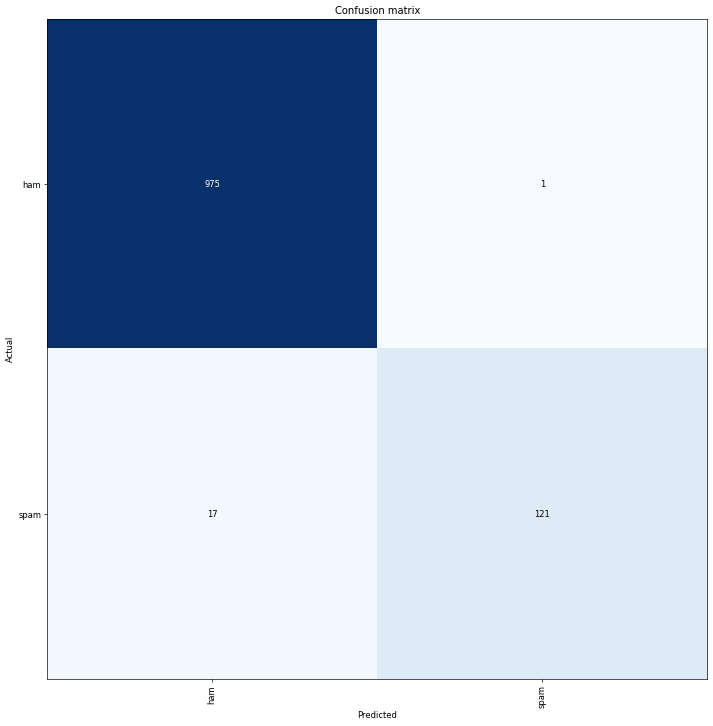

In [214]:
conf = ClassificationInterpretation.from_learner(learn_bal)
conf.plot_confusion_matrix(figsize=(12,12), dpi=60)